<center>
    <h1> ILI285 - Computación Científica I  / INF285 - Computación Científica </h1>
    <h2> Roots of 1D equations </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.32</h2>
</center>

## Table of Contents
* [Introduction](#intro)
* [Bisection Method](#bisection)
* [Cobweb Plot](#cobweb)
* [Fixed Point Iteration](#fpi)
* [Newton Method](#nm)
* [Wilkinson Polynomial](#wilkinson)
* [Acknowledgements](#acknowledgements)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
%matplotlib inline
from ipywidgets import interact
from ipywidgets import widgets
sym.init_printing()
from scipy import optimize

<div id='intro' />

## Introduction

Hello again! In this document we're going to learn how to find a 1D equation's solution using numerical methods. First, let's start with the definition of a root:

<b>Definition</b>: The function $f(x)$ has a <b>root</b> in $x = r$ if $f(r) = 0$.

An example: Let's say we want to solve the equation $x + \log(x) = 3$. We can rearrange the equation: $x + \log(x) - 3 = 0$. That way, to find its solution we can find the root of $f(x) = x + \log(x) - 3$. Now let's study some numerical methods to solve these kinds of problems. 

Defining a function $f(x)$

In [2]:
f = lambda x: x+np.log(x)-3

Finding $r$ using sympy

In [3]:
y = sym.Symbol('y')
fsym = lambda y: y+sym.log(y)-3
r_all=sym.solve(sym.Eq(fsym(y), 0), y)
r=r_all[0].evalf()
print(r)
print(r_all)

2.20794003156932
[LambertW(exp(3))]


In [4]:
def find_root_manually(r=2.0): 
    x = np.linspace(1,3,1000)
    plt.figure(figsize=(8,8))
    plt.plot(x,f(x),'b-')
    plt.grid()
    plt.ylabel('$f(x)$',fontsize=16)
    plt.xlabel('$x$',fontsize=16)
    plt.title('What is r such that $f(r)='+str(f(r))+'$? $r='+str(r)+'$',fontsize=16)
    plt.plot(r,f(r),'k.',markersize=20)
    plt.show()
interact(find_root_manually,r=(1e-5,3,1e-3))

interactive(children=(FloatSlider(value=2.0, description='r', max=3.0, min=1e-05, step=0.001), Output()), _dom…

<function __main__.find_root_manually(r=2.0)>

<div id='bisection' />

## Bisection Method

The bisection method finds the root of a function $f$, where $f$ is a **continuous** function.
If we want to know if this has a root, we have to check if there is an interval $[a,b]$ for which 
$f(a)\cdot f(b) < 0$. When these 2 conditions are satisfied, it means that there is a value $r$, between $a$ and $b$, for which $f(r) = 0$. To summarize how this method works, start with the aforementioned interval (checking that there's a root in it), and split it into two smaller intervals $[a,c]$ and $[c,b]$. Then, check which of the two intervals contains a root. Keep splitting each "eligible" interval until the algorithm converges or the tolerance is surpassed.

In [5]:
def bisect(f, a, b, tol=1e-8):
    fa = f(a)
    fb = f(b)
    i = 0
    # Just checking if the sign is not negative => not root  necessarily 
    if np.sign(f(a)*f(b)) >= 0:
        print('f(a)f(b)<0 not satisfied!')
        return None
  
    #Printing the evolution of the computation of the root
    print(' i |     a     |     c     |     b     |     fa    |     fc     |     fb     |   b-a')
    print('----------------------------------------------------------------------------------------')
    
    while(b-a)/2 > tol:
        c = (a+b)/2.
        fc = f(c)
        print('%2d | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f' %
              (i+1, a, c, b, fa, fc, fb, b-a))
        # Did we find the root?
        if fc == 0:
            print('f(c)==0')
            break
        elif np.sign(fa*fc) < 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
        i += 1
        
    xc = (a+b)/2.
    return xc

In [6]:
## Finding a root of cos(x). What about if you change the interval?
#f = lambda x: np.cos(x)
## Another function
#f = lambda x: x**3-2*x**2+(4/3)*x-(8/27)
## Computing the cubic root of 7.
#f = lambda x: x**3-7
#bisect(f,0,2)
f = lambda x: x*np.exp(x)-3
#f2 = lambda x: np.cos(x)-x
bisect(f,0,3,tol=1e-13)

 i |     a     |     c     |     b     |     fa    |     fc     |     fb     |   b-a
----------------------------------------------------------------------------------------
 1 | 0.0000000 | 1.5000000 | 3.0000000 | -3.0000000 | 3.7225336 | 57.2566108 | 3.0000000
 2 | 0.0000000 | 0.7500000 | 1.5000000 | -3.0000000 | -1.4122500 | 3.7225336 | 1.5000000
 3 | 0.7500000 | 1.1250000 | 1.5000000 | -1.4122500 | 0.4652440 | 3.7225336 | 0.7500000
 4 | 0.7500000 | 0.9375000 | 1.1250000 | -1.4122500 | -0.6060099 | 0.4652440 | 0.3750000
 5 | 0.9375000 | 1.0312500 | 1.1250000 | -0.6060099 | -0.1077879 | 0.4652440 | 0.1875000
 6 | 1.0312500 | 1.0781250 | 1.1250000 | -0.1077879 | 0.1687856 | 0.4652440 | 0.0937500
 7 | 1.0312500 | 1.0546875 | 1.0781250 | -0.1077879 | 0.0280899 | 0.1687856 | 0.0468750
 8 | 1.0312500 | 1.0429688 | 1.0546875 | -0.1077879 | -0.0404419 | 0.0280899 | 0.0234375
 9 | 1.0429688 | 1.0488281 | 1.0546875 | -0.0404419 | -0.0063254 | 0.0280899 | 0.0117188
10 | 1.0488281 | 1.0517578 |

It's very important to define a concept called **convergence rate**. 
This rate shows how fast the convergence of a method is at a specified point.

The convergence rate for the bisection is always 0.5 because this method uses the half of the interval for each iteration.

<div id='cobweb' />

## Cobweb Plot

In [7]:
def cobweb(x,g=None):
    min_x = np.amin(x)
    max_x = np.amax(x)
    
    plt.figure(figsize=(10,10))
    ax = plt.axes()
    plt.plot(np.array([min_x,max_x]),np.array([min_x,max_x]),'b-')
    for i in np.arange(x.size-1):
        delta_x = x[i+1]-x[i]
        head_length =  np.abs(delta_x)*0.04
        arrow_length = delta_x-np.sign(delta_x)*head_length
        ax.arrow(x[i], x[i], 0, arrow_length, head_width=1.5*head_length, head_length=head_length, fc='k', ec='k')
        ax.arrow(x[i], x[i+1], arrow_length, 0, head_width=1.5*head_length, head_length=head_length, fc='k', ec='k')
    
    if g!=None:
        y = np.linspace(min_x,max_x,1000)
        plt.plot(y,g(y),'r')
    
    plt.title('Cobweb diagram')
    plt.grid(True)
    plt.show()

<div id='fpi' />

## Fixed Point Iteration

To learn about the Fixed-Point Iteration we will first learn about the concept of Fixed Point.

A Fixed Point of a function $g$ is a real number $r$, where $g(r) = r$

The Fixed-Point Iteration is based in the Fixed Point concept and works like this to find the root of a function:

\begin{equation} x_{0} = initial\_guess \\ x_{i+1} = g(x_{i})\end{equation}

To find an equation's solution using this method you'll have to move around some things to rearrange the equation in the form $x = g(x)$. That way, you'll be iterating over the funcion $g(x)$, but you will **not** find $g$'s root, but $f(x) = g(x) - x$ (or $f(x) = x - g(x)$)'s root. In our following example, we'll find the solution to $f(x) = x - \cos(x)$ by iterating over the funcion $g(x) = \cos(x)$.



In [8]:
def fpi(g, x0, k, flag_cobweb=False):
    x = np.empty(k+1)
    x[0] = x0
    error_i = np.nan
    
    print(' i |     x(i)     |    x(i+1)    ||x(i+1)-x(i)| | e_i/e_{i-1}')
    print('--------------------------------------------------------------')
    
    for i in range(k):
        x[i+1] = g(x[i])
        error_iminus1 = error_i
        error_i = abs(x[i+1]-x[i])
        print('%2d | %.10f | %.10f | %.10f | %.10f' %
              (i,x[i],x[i+1],error_i,error_i/error_iminus1))
    if flag_cobweb:
        cobweb(x,g)
    return x[-1]

 i |     x(i)     |    x(i+1)    ||x(i+1)-x(i)| | e_i/e_{i-1} | e_i/e_{i-1}^2
-----------------------------------------------------------------------------
 0 | 2.0000000000 | -0.4161468365 | 2.4161468365 | 0.0000000000 | 0.0000000000
 1 | -0.4161468365 | 0.9146533259 | 1.3308001624 | 0.5507944063 | 0.2279639623
 2 | 0.9146533259 | 0.6100652997 | 0.3045880261 | 0.2288758558 | 0.1719836398
 3 | 0.6100652997 | 0.8196106080 | 0.2095453083 | 0.6879630527 | 2.2586674253
 4 | 0.8196106080 | 0.6825058579 | 0.1371047501 | 0.6542964443 | 3.1224580961
 5 | 0.6825058579 | 0.7759946131 | 0.0934887552 | 0.6818783095 | 4.9734112712
 6 | 0.7759946131 | 0.7137247340 | 0.0622698791 | 0.6660681166 | 7.1245800092
 7 | 0.7137247340 | 0.7559287136 | 0.0422039796 | 0.6777591376 | 10.8842211877
 8 | 0.7559287136 | 0.7276347923 | 0.0282939213 | 0.6704088465 | 15.8849675651
 9 | 0.7276347923 | 0.7467496017 | 0.0191148094 | 0.6755800739 | 23.8772161593
10 | 0.7467496017 | 0.7339005972 | 0.0128490045 | 0.6722015

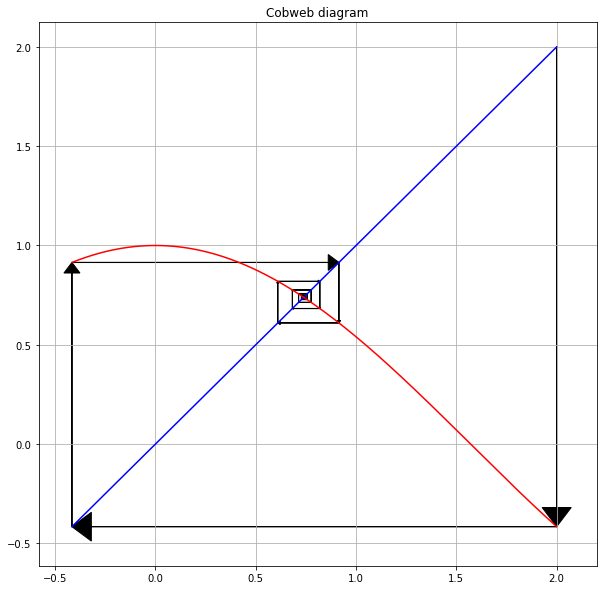

In [11]:
g = lambda x: np.cos(x)
fpi2(g, 2, 20, True)

Let's quickly explain the Cobweb Diagram we have here. The <font color="blue">blue</font> line is the function $x$ and the <font color="red">red</font> is the function $g(x)$. The point in which they meet is $g$'s fixed point. In this particular example, we start at <font color="blue">$y = x = 1.5$</font> (the top right corner) and then we "jump" **vertically** to <font color="red">$y = \cos(1.5) \approx 0.07$</font>. After this, we jump **horizontally** to <font color="blue">$x = \cos(1.5) \approx 0.07$</font>. Then, we jump again **vertically** to <font color="red">$y = \cos\left(\cos(1.5)\right) \approx 0.997$</font> and so on. See the pattern here? We're just iterating over $x = \cos(x)$, getting closer to the center of the diagram where the fixed point resides, in $x \approx 0.739$.

It's very important to mention that the algorithm will converge only if the rate of convergence $S < 1$, where $S = \left| g'(r) \right|$. If you want to use this method, you'll have to construct $g(x)$ starting from $f(x)$ accordingly. In this example, $g(x) = \cos(x) \Rightarrow g'(x) = -\sin(x)$ and $|-\sin(0.739)| \approx 0.67$.

### Another example. Source: https://divisbyzero.com/2008/12/18/sharkovskys-theorem/amp/?__twitter_impression=true

 i |     x(i)     |    x(i+1)    ||x(i+1)-x(i)| | e_i/e_{i-1}
--------------------------------------------------------------
 0 | 2.4500000000 | 2.4578703704 | 0.0078703704 | nan
 1 | 2.4578703704 | 2.4573987149 | 0.0004716554 | 0.0599279835
 2 | 2.4573987149 | 2.4574289190 | 0.0000302040 | 0.0640383807
 3 | 2.4574289190 | 2.4574269922 | 0.0000019268 | 0.0637931300
 4 | 2.4574269922 | 2.4574271151 | 0.0000001229 | 0.0638088397
 5 | 2.4574271151 | 2.4574271073 | 0.0000000078 | 0.0638078348
 6 | 2.4574271073 | 2.4574271078 | 0.0000000005 | 0.0638078595
 7 | 2.4574271078 | 2.4574271078 | 0.0000000000 | 0.0638072307
 8 | 2.4574271078 | 2.4574271078 | 0.0000000000 | 0.0638043463
 9 | 2.4574271078 | 2.4574271078 | 0.0000000000 | 0.0634125082
10 | 2.4574271078 | 2.4574271078 | 0.0000000000 | 0.0618556701
11 | 2.4574271078 | 2.4574271078 | 0.0000000000 | 0.1111111111


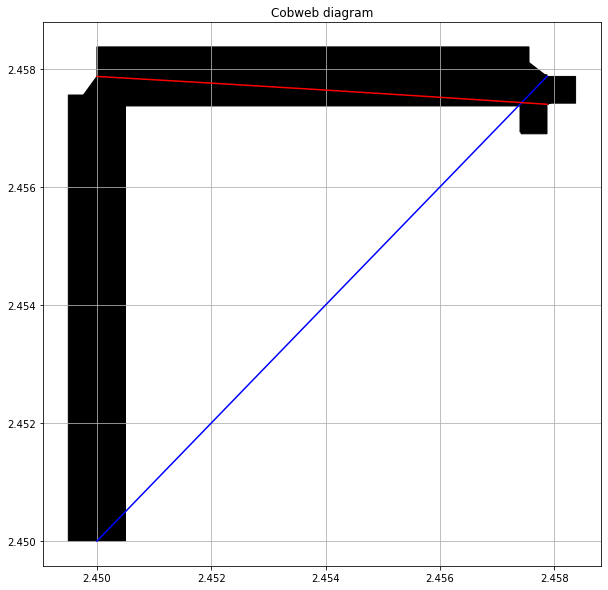

In [12]:
g = lambda x: -(3/2)*x**2+(11/2)*x-2
gp = lambda x: -3*x+11/2

a=-1/2.7
g2 = lambda x: x+a*(x-g(x))

#x=np.linspace(2,3,100)
#plt.plot(x,gp(x),'-')
#plt.plot(x,gp(x)*0+1,'r-')
#plt.plot(x,gp(x)*0-1,'g-')
#plt.grid(True)
#plt.show()
fpi(g2, 2.45, 12, True)

<div id='nm' />

## Newton's Method

For this method, we want to iteratively find some function $f(x)$'s root, that is, the number $r$ for which $f(r) = 0$. The algorithm is as follows:

\begin{equation} x_0 = initial\_guess \end{equation}
\begin{equation} x_{i+1} = x_i - \cfrac{f(x_i)}{f'(x_i)} \end{equation}

which means that you won't be able to find $f$'s root if $f'(r) = 0$. In this case, you would have to use the modified version of this method, but for now let's focus on the unmodified version first. Newton's (unmodified) method is said to have quadratic convergence.

In [13]:
def newton_method(f, fp, x0, rel_error=1e-8, m=1):
    #Initialization of hybrid error and absolute
    hybrid_error = 100
    error_i = np.inf
    
    print('i |     x(i)     |     x(i+1)   |      |x(i+1)-x(i)|     |  e_i/e_{i-1} | e_i/e_{i-1}^2')
    print('----------------------------------------------------------------------------------------')
    
    #Iteration counter
    i = 1
    while (hybrid_error > rel_error and hybrid_error < 1e12 and i < 1e4):
        #Newton's iteration
        x1 = x0-m*f(x0)/fp(x0)
        
        #Checking if root was found
        if f(x1) == 0.0:
            hybrid_error = 0.0
            break
        
        #Computation of hybrid error
        hybrid_error = abs(x1-x0)/np.max([abs(x1),1e-12])
        
        #Computation of absolute error
        error_iminus1 = error_i
        error_i = abs(x1-x0)
        
        #Increasing counter
        i += 1
        
        #Showing some info
        print("%d | %.10f | %.10f | %.20f | %.10f | %.10f" % 
              (i, x0, x1, error_i, error_i/error_iminus1, error_i/(error_iminus1**2)))
        #Updating solution
        x0 = x1
    
    #Checking if solution was obtained
    if hybrid_error < rel_error: 
        return x1
    elif i>=1e4:
        print('Newton''s Method diverged. Too many iterations!!')
        return None
    else:
        print('Newton''s Method diverged!')
        return None

In [14]:
f = lambda x: np.sin(x)
fp = lambda x: np.cos(x) # the derivative of f
newton_method(f, fp, 3.1,rel_error=1e-14)

i |     x(i)     |     x(i+1)   |      |x(i+1)-x(i)|     |  e_i/e_{i-1} | e_i/e_{i-1}^2
----------------------------------------------------------------------------------------
2 | 3.1000000000 | 3.1416166546 | 0.04161665458563579278 | 0.0000000000 | 0.0000000000
3 | 3.1416166546 | 3.1415926536 | 0.00002400099584720650 | 0.0005767161 | 0.0138578204
4 | 3.1415926536 | 3.1415926536 | 0.00000000000000444089 | 0.0000000002 | 0.0000077092


In [15]:
f = lambda x: x**2
fp = lambda x: 2*x # the derivative of f
newton_method(f, fp, 3.1,rel_error=1e-2, m=2)

i |     x(i)     |     x(i+1)   |      |x(i+1)-x(i)|     |  e_i/e_{i-1} | e_i/e_{i-1}^2
----------------------------------------------------------------------------------------


<div id='wilkinson' />

## Wilkinson Polynomial
https://en.wikipedia.org/wiki/Wilkinson%27s_polynomial

**Final question: Why is the root far far away from $16$?**

In [ ]:
x = sym.symbols('x', reals=True)
W=1
for i in np.arange(1,21):
        W*=(x-i)
W # Printing W nicely

In [ ]:
# Expanding the Wilkinson polynomial
We=sym.expand(W)
We 

In [ ]:
# Just computiong the derivative
Wep=sym.diff(We,x)
Wep

In [ ]:
# Lamdifying the polynomial to be used with sympy
P=sym.lambdify(x,We)
Pp=sym.lambdify(x,Wep)

In [ ]:
# Using scipy function to compute a root
root = optimize.newton(P,16)
print(root)

<div id='acknowledgements' />

# Acknowledgements
* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. DI UTFSM. March 2016._ v1.1.
* _Update April 2020 - v1.32 - C.Torres_ : Re-ordering the notebook.

# Propose Classwork
Build a FPI such that given $x$ computes $\displaystyle \frac{1}{x}$. Write down your solution below or go and see the [solution](#sol1)

In [ ]:
print('Please try to think and solve before you see the solution!!!')

# In class

### From the textbook

 i |     x(i)     |    x(i+1)    ||x(i+1)-x(i)| | e_i/e_{i-1}
--------------------------------------------------------------
 0 | 0.5000000000 | 0.7142857143 | 0.2142857143 | nan
 1 | 0.7142857143 | 0.6831797235 | 0.0311059908 | 0.1451612903
 2 | 0.6831797235 | 0.6823284233 | 0.0008513002 | 0.0273677249
 3 | 0.6823284233 | 0.6823278038 | 0.0000006195 | 0.0007276825
 4 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 0.0000005291
 5 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 0.0003387534
 6 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 1.0000000000
 7 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 1.0000000000
 8 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 1.0000000000
 9 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 1.0000000000


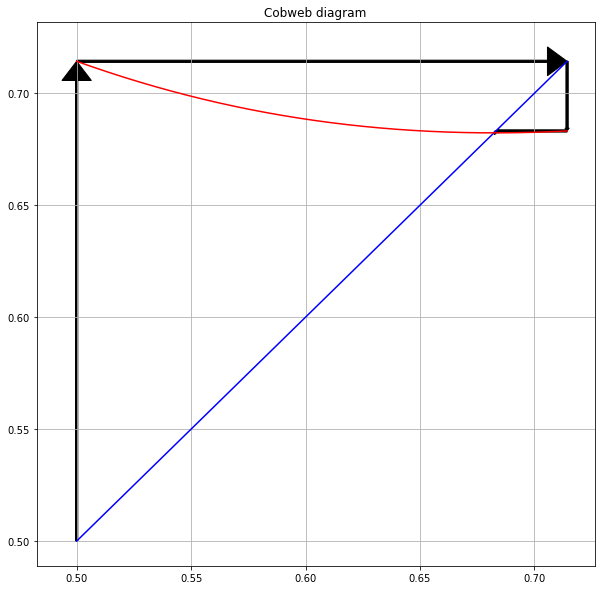

In [16]:
g1 = lambda x: 1-x**3
g2 = lambda x: (1-x)**(1/3)
g3 = lambda x: (1+2*x**3)/(1+3*x**2)
fpi(g3, 0.5, 10, True)

In [17]:
g1p = lambda x: -3*x**2
g2p = lambda x: -(1/3)*(1-x)**(-2/3)
g3p = lambda x: ((1+3*x**2)*(6*x**2)-(1+2*x**3)*6*x)/((1+3*x**2)**2)
r=0.6823278038280194
print(g3p(r))

0.0


### Adding another implementation of FPI including and extra column for analyzing quadratic convergence

In [18]:
def fpi2(g, x0, k, flag_cobweb=False):
    x = np.empty(k+1)
    x[0] = x0
    error_i = np.inf
    
    print(' i |     x(i)     |    x(i+1)    ||x(i+1)-x(i)| | e_i/e_{i-1} | e_i/e_{i-1}^2')
    print('-----------------------------------------------------------------------------')
    
    for i in range(k):
        x[i+1] = g(x[i])
        error_iminus1 = error_i
        error_i = abs(x[i+1]-x[i])
        print('%2d | %.10f | %.10f | %.10f | %.10f | %.10f' %
              (i,x[i],x[i+1],error_i,error_i/error_iminus1,error_i/(error_iminus1**2)))
    if flag_cobweb:
        cobweb(x,g)
    return x[-1]

Which function shows quadratic convergence? Why?

 i |     x(i)     |    x(i+1)    ||x(i+1)-x(i)| | e_i/e_{i-1} | e_i/e_{i-1}^2
-----------------------------------------------------------------------------
 0 | 3.0000000000 | 2.7333333333 | 0.2666666667 | 0.0000000000 | 0.0000000000
 1 | 2.7333333333 | 2.5525203252 | 0.1808130081 | 0.6780487805 | 2.5426829268
 2 | 2.5525203252 | 2.4337859123 | 0.1187344129 | 0.6566696394 | 3.6317610455
 3 | 2.4337859123 | 2.3579112134 | 0.0758746990 | 0.6390287123 | 5.3820008621
 4 | 2.3579112134 | 2.3104331500 | 0.0474780634 | 0.6257430215 | 8.2470577167
 5 | 2.3104331500 | 2.2811657946 | 0.0292673554 | 0.6164395368 | 12.9836706220
 6 | 2.2811657946 | 2.2633049812 | 0.0178608134 | 0.6102639994 | 20.8513543865
 7 | 2.2633049812 | 2.2524757347 | 0.0108292465 | 0.6063131795 | 33.9465604055
 8 | 2.2524757347 | 2.2459365357 | 0.0065391990 | 0.6038461667 | 55.7606814775
 9 | 2.2459365357 | 2.2419977848 | 0.0039387509 | 0.6023292551 | 92.1105557855
10 | 2.2419977848 | 2.2396289986 | 0.0023687862 | 0.6014054

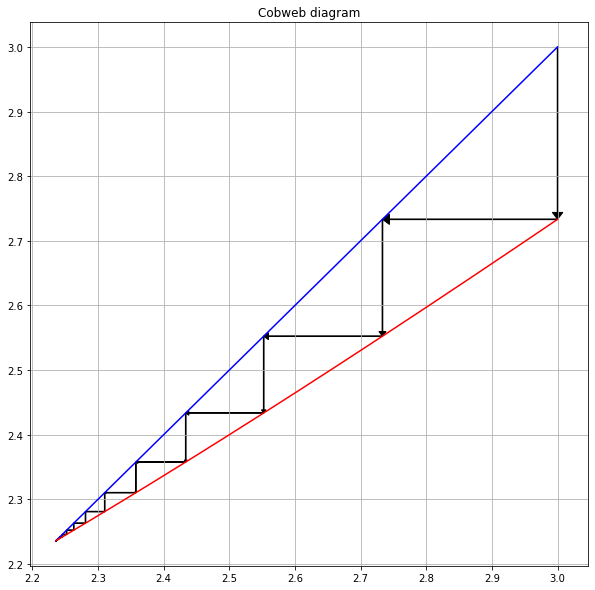

In [19]:
g1 = lambda x: (4./5.)*x+1./x
g2 = lambda x: x/2.+5./(2*x)
g3 = lambda x: (x+5.)/(x+1)
fpi2(g1, 3.0, 30, True)

### Building a FPI to compute the cubic root of 7

In [20]:
# What is 'a'? Can we find another 'a'?
a = -3*(1.7**2)
print(a)

-8.669999999999998


 i |     x(i)     |    x(i+1)    ||x(i+1)-x(i)| | e_i/e_{i-1}
--------------------------------------------------------------
 0 | 1.7000000000 | 1.9407151096 | 0.2407151096 | nan
 1 | 1.9407151096 | 1.9050217836 | 0.0356933259 | 0.1482803717
 2 | 1.9050217836 | 1.9149952799 | 0.0099734962 | 0.2794218792
 3 | 1.9149952799 | 1.9123789078 | 0.0026163720 | 0.2623324846
 4 | 1.9123789078 | 1.9130779941 | 0.0006990863 | 0.2671968386
 5 | 1.9130779941 | 1.9128920879 | 0.0001859062 | 0.2659273937
 6 | 1.9128920879 | 1.9129415886 | 0.0000495007 | 0.2662670485
 7 | 1.9129415886 | 1.9129284127 | 0.0000131759 | 0.2661767579
 8 | 1.9129284127 | 1.9129319201 | 0.0000035074 | 0.2662008017
 9 | 1.9129319201 | 1.9129309865 | 0.0000009337 | 0.2661944019
10 | 1.9129309865 | 1.9129312350 | 0.0000002485 | 0.2661961056
11 | 1.9129312350 | 1.9129311689 | 0.0000000662 | 0.2661956523
12 | 1.9129311689 | 1.9129311865 | 0.0000000176 | 0.2661957723
13 | 1.9129311865 | 1.9129311818 | 0.0000000047 | 0.2661957414


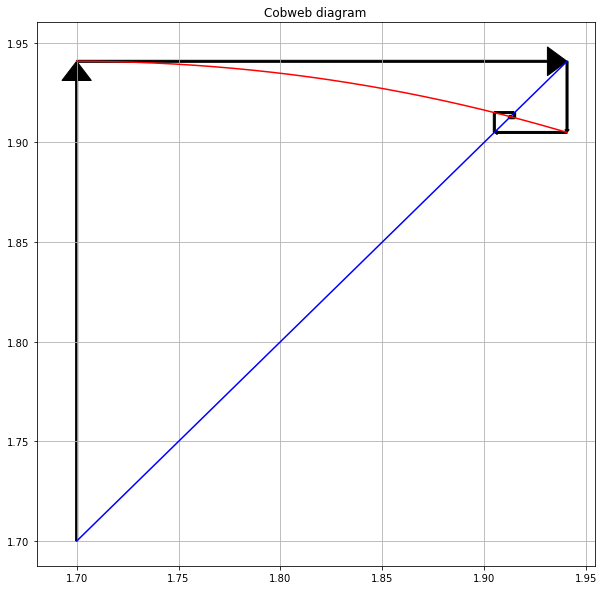

-1.0819690920982339e-08


In [21]:
f = lambda x: x**3-7
g =  lambda x: f(x)/a+x
r=fpi(g, 1.7, 14, True)
print(f(r))

### Playing with some roots

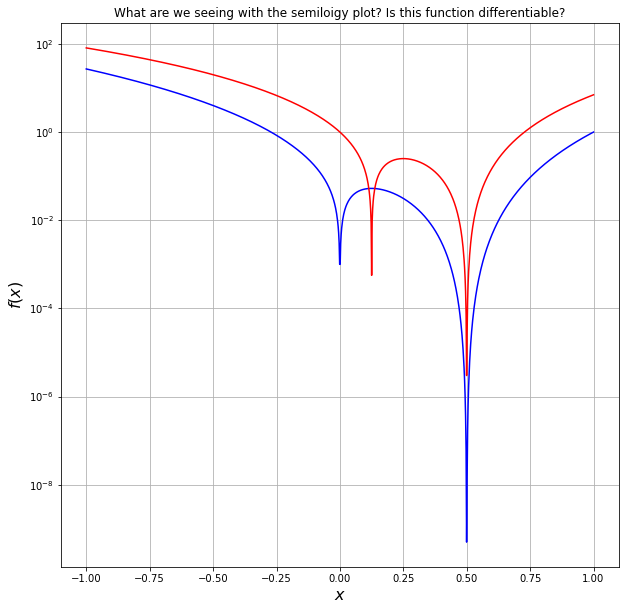

In [22]:
f = lambda x: 8*x**4-12*x**3+6*x**2-x
fp = lambda x: 32*x**3-36*x**2+12*x-1

x = np.linspace(-1,1,1000)
plt.figure(figsize=(10,10))

plt.title('What are we seeing with the semiloigy plot? Is this function differentiable?')
plt.semilogy(x,np.abs(f(x)),'b-')
plt.semilogy(x,np.abs(fp(x)),'r-')
plt.grid()
plt.ylabel('$f(x)$',fontsize=16)
plt.xlabel('$x$',fontsize=16)
plt.show()

In [24]:
r=newton_method(f, fp, 0.3, rel_error=1e-8, m=1)
print([r,f(r)])
# Is this showing quadratic convergence? If not, can you fix it?

i |     x(i)     |     x(i+1)   |      |x(i+1)-x(i)|     |  e_i/e_{i-1} | e_i/e_{i-1}^2
----------------------------------------------------------------------------------------
2 | 0.3000000000 | 0.3857142857 | 0.08571428571428552079 | 0.0000000000 | 0.0000000000
3 | 0.3857142857 | 0.4279843444 | 0.04227005870841460400 | 0.4931506849 | 5.7534246575
4 | 0.4279843444 | 0.4534159993 | 0.02543165489222543041 | 0.6016470208 | 14.2334086872
5 | 0.4534159993 | 0.4694946399 | 0.01607864055554952820 | 0.6322294252 | 24.8599404138
6 | 0.4694946399 | 0.4798882000 | 0.01039356016793291371 | 0.6464203321 | 40.2036683316
7 | 0.4798882000 | 0.4866871127 | 0.00679891264490944947 | 0.6541466576 | 62.9376890188
8 | 0.4866871127 | 0.4911655766 | 0.00447846388652911598 | 0.6587029604 | 96.8835745915
9 | 0.4911655766 | 0.4941281466 | 0.00296257004712746630 | 0.6615147788 | 147.7101960697
10 | 0.4941281466 | 0.4960932149 | 0.00196506826728892747 | 0.6632984996 | 223.8929338621
11 | 0.4960932149 | 0.49739890

# Solutions

<div id='sol1' />
Problem: Build a FPI such that given $x$ computes $\displaystyle \frac{1}{x}$

 i |     x(i)     |    x(i+1)    ||x(i+1)-x(i)| | e_i/e_{i-1} | e_i/e_{i-1}^2
-----------------------------------------------------------------------------
 0 | 0.7000000000 | 0.3710000000 | 0.3290000000 | 0.0000000000 | 0.0000000000
 1 | 0.3710000000 | 0.4529539000 | 0.0819539000 | 0.2491000000 | 0.7571428571
 2 | 0.4529539000 | 0.4750566054 | 0.0221027054 | 0.2696968100 | 3.2908355795
 3 | 0.4750566054 | 0.4761877763 | 0.0011311709 | 0.0511779387 | 2.3154603813
 4 | 0.4761877763 | 0.4761904762 | 0.0000026999 | 0.0023867984 | 2.1100246103
 5 | 0.4761904762 | 0.4761904762 | 0.0000000000 | 0.0000056698 | 2.1000206476
 6 | 0.4761904762 | 0.4761904762 | 0.0000000000 | 0.0000000000 | 0.0000000000


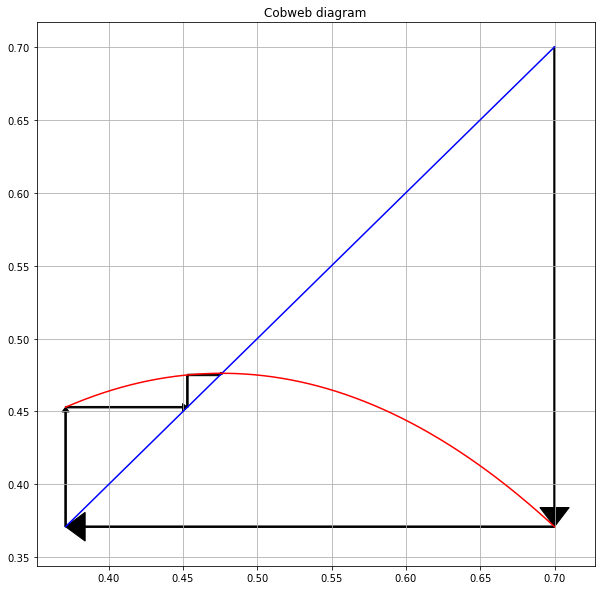

[0.47619047619047616, 0.47619047619047616]


In [25]:
# We are finding the 1/a
# Solution code:
a = 2.1
g = lambda x: 2*x-a*x**2
gp = lambda x: 2-2*a*x
r=fpi2(g, 0.7, 7, flag_cobweb=True)
print([r,1/a])
# Are we seeing quadratic convergence?

### What is this plot telling us?

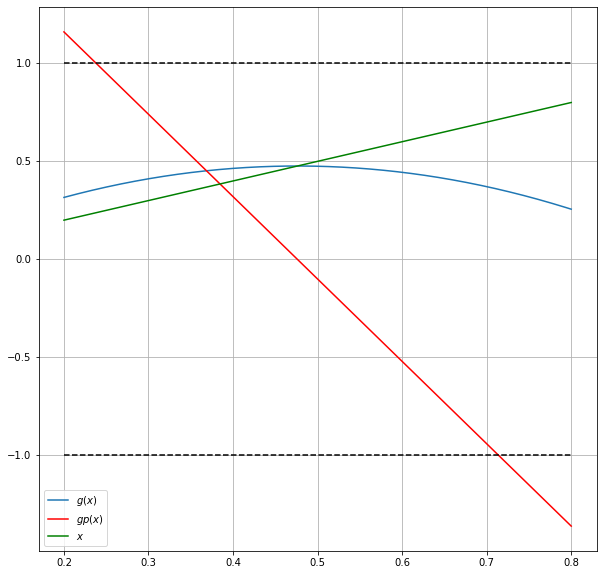

In [26]:
xx=np.linspace(0.2,0.8,1000)
plt.figure(figsize=(10,10))
plt.plot(xx,g(xx),'-',label=r'$g(x)$')
plt.plot(xx,gp(xx),'r-',label=r'$gp(x)$')
plt.plot(xx,xx,'g-',label=r'$x$')
plt.plot(xx,0*xx+1,'k--')
plt.plot(xx,0*xx-1,'k--')
plt.legend(loc='best')
plt.grid()
plt.show()